# Аспектный сентимент-анализ

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

torch.manual_seed(1)

## BIO-тэггинг для обучения модели

In [2]:
from dlnlputils.sentiment_utils import show_markup, prepare_data, generate_markup, parse_xml_aspect_sentiment

In [3]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [4]:
xml_train = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
xml_test  = 'datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'

In [5]:
texts_w_aspect_spans = parse_xml_aspect_sentiment(xml_train)
texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect_sentiment(xml_test)
texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

In [6]:
len(training_data), len(test_data)

(2210, 1922)

In [7]:
test_recipe, test_tags = training_data[400]
text, spans = generate_markup(test_recipe, test_tags)
show_markup(text, spans)

## Статистика по тэгам

In [8]:
from collections import Counter
from collections import defaultdict

def form_vocabulary_and_tagset(words_w_tags):
    dictionary = defaultdict(Counter)
    for words,tags in words_w_tags: 
        for word, tag in zip(words, tags):
            dictionary[tag].update([word])      
    return dictionary, set(dictionary.keys()) 

In [9]:
word_counter, labels = form_vocabulary_and_tagset(training_data)

In [10]:
for label in labels:
    num_words = len(word_counter[label])
    print(f'{num_words}\tin {label}')

305	in B-Reliability-negative
11	in B-Safety-unknown
67	in I-Whole-positive
290	in B-Comfort-positive
82	in B-Costs-negative
57	in I-Appearance-positive
7	in I-Costs-unknown
136	in I-Whole-unknown
109	in I-Driveability-unknown
5	in I-Safety-unknown
113	in I-Reliability-positive
59	in B-Reliability-unknown
29	in B-Costs-unknown
335	in B-Driveability-positive
157	in I-Driveability-negative
36	in I-Comfort-unknown
128	in I-Comfort-negative
24	in B-Safety-negative
23	in I-Safety-negative
52	in I-Costs-negative
197	in I-Reliability-negative
214	in B-Driveability-negative
67	in B-Comfort-unknown
33	in B-Safety-positive
136	in B-Whole-unknown
48	in B-Appearance-negative
200	in B-Comfort-negative
43	in I-Whole-negative
57	in I-Costs-positive
210	in I-Driveability-positive
114	in B-Appearance-positive
61	in B-Whole-negative
20	in I-Appearance-negative
40	in I-Appearance-unknown
162	in I-Comfort-positive
4933	in Other-unknown
28	in I-Reliability-unknown
59	in B-Appearance-unknown
174	in B-Drivea

In [11]:
word_counter['B-Comfort-positive'].most_common()#[-1]

[('салон', 45),
 ('просторный', 31),
 ('багажник', 31),
 ('вместительный', 25),
 ('удобно', 21),
 ('удобный', 19),
 ('салоне', 14),
 ('удобные', 13),
 ('комфортно', 13),
 ('удобная', 13),
 ('не', 12),
 ('места', 11),
 ('комфортный', 11),
 ('шумоизоляция', 10),
 ('сиденья', 7),
 ('много', 7),
 ('подогрев', 6),
 ('машина', 6),
 ('удобен', 6),
 ('большой', 6),
 ('комфортная', 6),
 ('комфорт', 6),
 ('панель', 6),
 ('кондиционер', 5),
 ('удобство', 5),
 ('комфортабельный', 5),
 ('автомобиль', 4),
 ('удобным', 4),
 ('просторно', 4),
 ('сидеть', 4),
 ('удобное', 4),
 ('климат', 4),
 ('огромный', 4),
 ('задние', 3),
 ('вместительность', 3),
 ('эргономика', 3),
 ('регулировка', 3),
 ('сидения', 3),
 ('комфорта', 3),
 ('багажное', 2),
 ('вместительная', 2),
 ('комфортных', 2),
 ('место', 2),
 ('магнитофон', 2),
 ('кожаный', 2),
 ('сенсорный', 2),
 ('кузов', 2),
 ('руль', 2),
 ('ручка', 2),
 ('печка', 2),
 ('обдув', 2),
 ('с', 2),
 ('базовой', 2),
 ('машинка', 2),
 ('просторная', 2),
 ('салоном',

In [12]:
class TagConverter():
    def __init__(self, tags):
        self.idx_to_tag  = sorted(tags)
        self.tag_to_idx  = {tag:idx for idx,tag in enumerate(self.idx_to_tag)}
        
    def tags_to_index(self, words):
        return torch.tensor([self.tag_to_idx[w] for w in words], dtype=torch.long)
    
    def indices_to_tags(self, indices):
        return [self.idx_to_tag[i] for i in indices]

In [13]:
tag_converter = TagConverter(labels)

In [14]:
test_recipe, test_tags = training_data[321]

# оригинал
text, spans = generate_markup(test_recipe, test_tags) 
show_markup(text, spans)

# закодированные тэги:
encoded_tags = tag_converter.tags_to_index(test_tags)
print(encoded_tags)
print()

# декодированные тэги:
decoded_tags = tag_converter.indices_to_tags(encoded_tags)
text, spans = generate_markup(test_recipe, decoded_tags) 
show_markup(text, spans)

tensor([20, 42, 42, 42])



## fastText

In [15]:
import gensim
# import wget

In [16]:
# model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
# wget.download(model_url)

In [17]:
w2v_model = gensim.models.KeyedVectors.load('datasets/187/model.model')

In [18]:
# words = ['тачка', 'двигатель']
#
# for word in words:
#     print(word)
#
#     for i in w2v_model.most_similar(positive=[word], topn=10):
#         nearest_word      = i[0]
#         cosine_similarity = i[1]
#         print(nearest_word, cosine_similarity)
#     print('\n')

Создадим конвертер слов в векторы fasttext:

In [19]:
class WordConverter:
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model

    def convert(self, words):
        embeddings = [self.w2v_model.get_vector(word) for word in words]
        embeddings = torch.FloatTensor(embeddings)
        return embeddings

In [20]:
word_converter = WordConverter(w2v_model)

words,_ = training_data[333]
vectors = word_converter.convert(words)

vectors.shape

/var/folders/3l/7hvfj3895f729zj8r810ttj00000gn/T/ipykernel_30626/2272054658.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  embeddings = torch.FloatTensor(embeddings)


torch.Size([27, 300])

##  LSTM

In [21]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
TAGSET_SIZE   = len(tag_converter.tag_to_idx)

In [22]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, word_converter):
        super(LSTMTagger, self).__init__()
        tagset_size = len(tag_converter.tag_to_idx)
        
        self.word_converter = word_converter
        self.lstm           = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag     = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, words):
        embeds      = self.word_converter.convert(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)  
        return tags_pred

In [23]:
for label in labels:
    num_words = len(word_counter[label])
    print(f'{num_words}\tin {label}')

305	in B-Reliability-negative
11	in B-Safety-unknown
67	in I-Whole-positive
290	in B-Comfort-positive
82	in B-Costs-negative
57	in I-Appearance-positive
7	in I-Costs-unknown
136	in I-Whole-unknown
109	in I-Driveability-unknown
5	in I-Safety-unknown
113	in I-Reliability-positive
59	in B-Reliability-unknown
29	in B-Costs-unknown
335	in B-Driveability-positive
157	in I-Driveability-negative
36	in I-Comfort-unknown
128	in I-Comfort-negative
24	in B-Safety-negative
23	in I-Safety-negative
52	in I-Costs-negative
197	in I-Reliability-negative
214	in B-Driveability-negative
67	in B-Comfort-unknown
33	in B-Safety-positive
136	in B-Whole-unknown
48	in B-Appearance-negative
200	in B-Comfort-negative
43	in I-Whole-negative
57	in I-Costs-positive
210	in I-Driveability-positive
114	in B-Appearance-positive
61	in B-Whole-negative
20	in I-Appearance-negative
40	in I-Appearance-unknown
162	in I-Comfort-positive
4933	in Other-unknown
28	in I-Reliability-unknown
59	in B-Appearance-unknown
174	in B-Drivea

In [24]:
from collections import Counter
from pprint import pprint

tag_counter = Counter()
for label in labels:
    tag_counter[label] = len(word_counter[label])
        
pprint(tag_counter.most_common())


class_weights = torch.ones(43)
class_divs    = torch.ones(43)

for tag, inv_weight in tag_counter.most_common():
    tag_idx             = tag_converter.tags_to_index([tag])
    class_divs[tag_idx] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))

class_weights /= class_divs

print(class_weights.detach())

[('Other-unknown', 4933),
 ('B-Driveability-positive', 335),
 ('B-Reliability-negative', 305),
 ('B-Comfort-positive', 290),
 ('B-Driveability-negative', 214),
 ('I-Driveability-positive', 210),
 ('B-Comfort-negative', 200),
 ('I-Reliability-negative', 197),
 ('B-Driveability-unknown', 174),
 ('I-Comfort-positive', 162),
 ('I-Driveability-negative', 157),
 ('B-Reliability-positive', 156),
 ('I-Whole-unknown', 136),
 ('B-Whole-unknown', 136),
 ('I-Comfort-negative', 128),
 ('B-Appearance-positive', 114),
 ('I-Reliability-positive', 113),
 ('I-Driveability-unknown', 109),
 ('B-Costs-positive', 100),
 ('B-Whole-positive', 96),
 ('B-Costs-negative', 82),
 ('I-Whole-positive', 67),
 ('B-Comfort-unknown', 67),
 ('B-Whole-negative', 61),
 ('B-Reliability-unknown', 59),
 ('B-Appearance-unknown', 59),
 ('I-Appearance-positive', 57),
 ('I-Costs-positive', 57),
 ('I-Costs-negative', 52),
 ('B-Appearance-negative', 48),
 ('I-Whole-negative', 43),
 ('I-Appearance-unknown', 40),
 ('I-Comfort-unknown

In [25]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, TAGSET_SIZE, word_converter)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

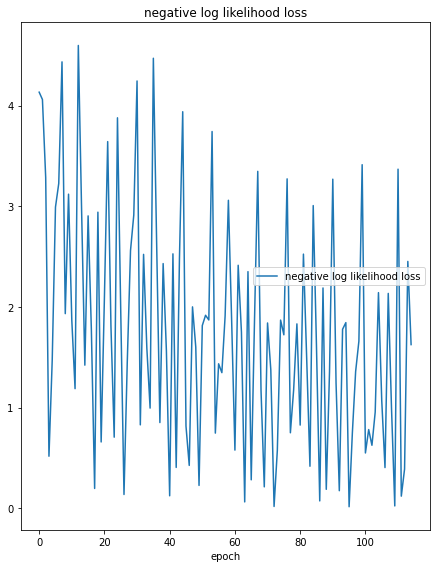

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.015, max:    4.598, cur:    1.626)


In [26]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(5): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        tag_predicted = model(recipe) # <- предложение, а не список индексов слов
        tag_ground    = tag_converter.tags_to_index(tags) 
        
        
        loss = loss_function(tag_predicted, tag_ground)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            liveplot.update({'negative log likelihood loss': loss})
            liveplot.draw()   

In [27]:
def predict_tags(model, recipe):
    encoded_tags   = model.predict_tags(recipe)      # предсказанные тэги (номера)
    decoded_tags   = tag_converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    return decoded_tags

In [28]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,1000)]
    
    tags_pred    = predict_tags(model, recipe)

    print('истинные тэги:')
    text, spans = generate_markup(recipe, tags) 
    show_markup(text, spans)

    print('предсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred) 

    show_markup(text, spans)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


In [29]:
from dlnlputils.sentiment_utils import plot_confusion_matrix

In [30]:
y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(model, sentence)
    y_true += tags

In [31]:
ordered_labels = [
    'Other-unknown',
    'B-Whole-positive', 'B-Whole-negative', 'B-Whole-unknown',
    'I-Whole-positive', 'I-Whole-negative', 'I-Whole-unknown',
    'B-Driveability-positive', 'B-Driveability-negative', 'B-Driveability-unknown',
    'I-Driveability-positive', 'I-Driveability-negative', 'I-Driveability-unknown',
    'B-Appearance-positive', 'B-Appearance-negative', 'B-Appearance-unknown',
    'I-Appearance-positive', 'I-Appearance-negative', 'I-Appearance-unknown',
    'B-Reliability-positive', 'B-Reliability-negative', 'B-Reliability-unknown',
    'I-Reliability-positive', 'I-Reliability-negative', 'I-Reliability-unknown',
    'B-Comfort-positive', 'B-Comfort-negative', 'B-Comfort-unknown',
    'I-Comfort-positive', 'I-Comfort-negative', 'I-Comfort-unknown',
    'B-Costs-positive', 'B-Costs-negative', 'B-Costs-unknown',
    'I-Costs-positive', 'I-Costs-negative', 'I-Costs-unknown',
    'B-Safety-positive', 'B-Safety-negative', 'B-Safety-unknown',
    'I-Safety-positive', 'I-Safety-negative', 'I-Safety-unknown'
]

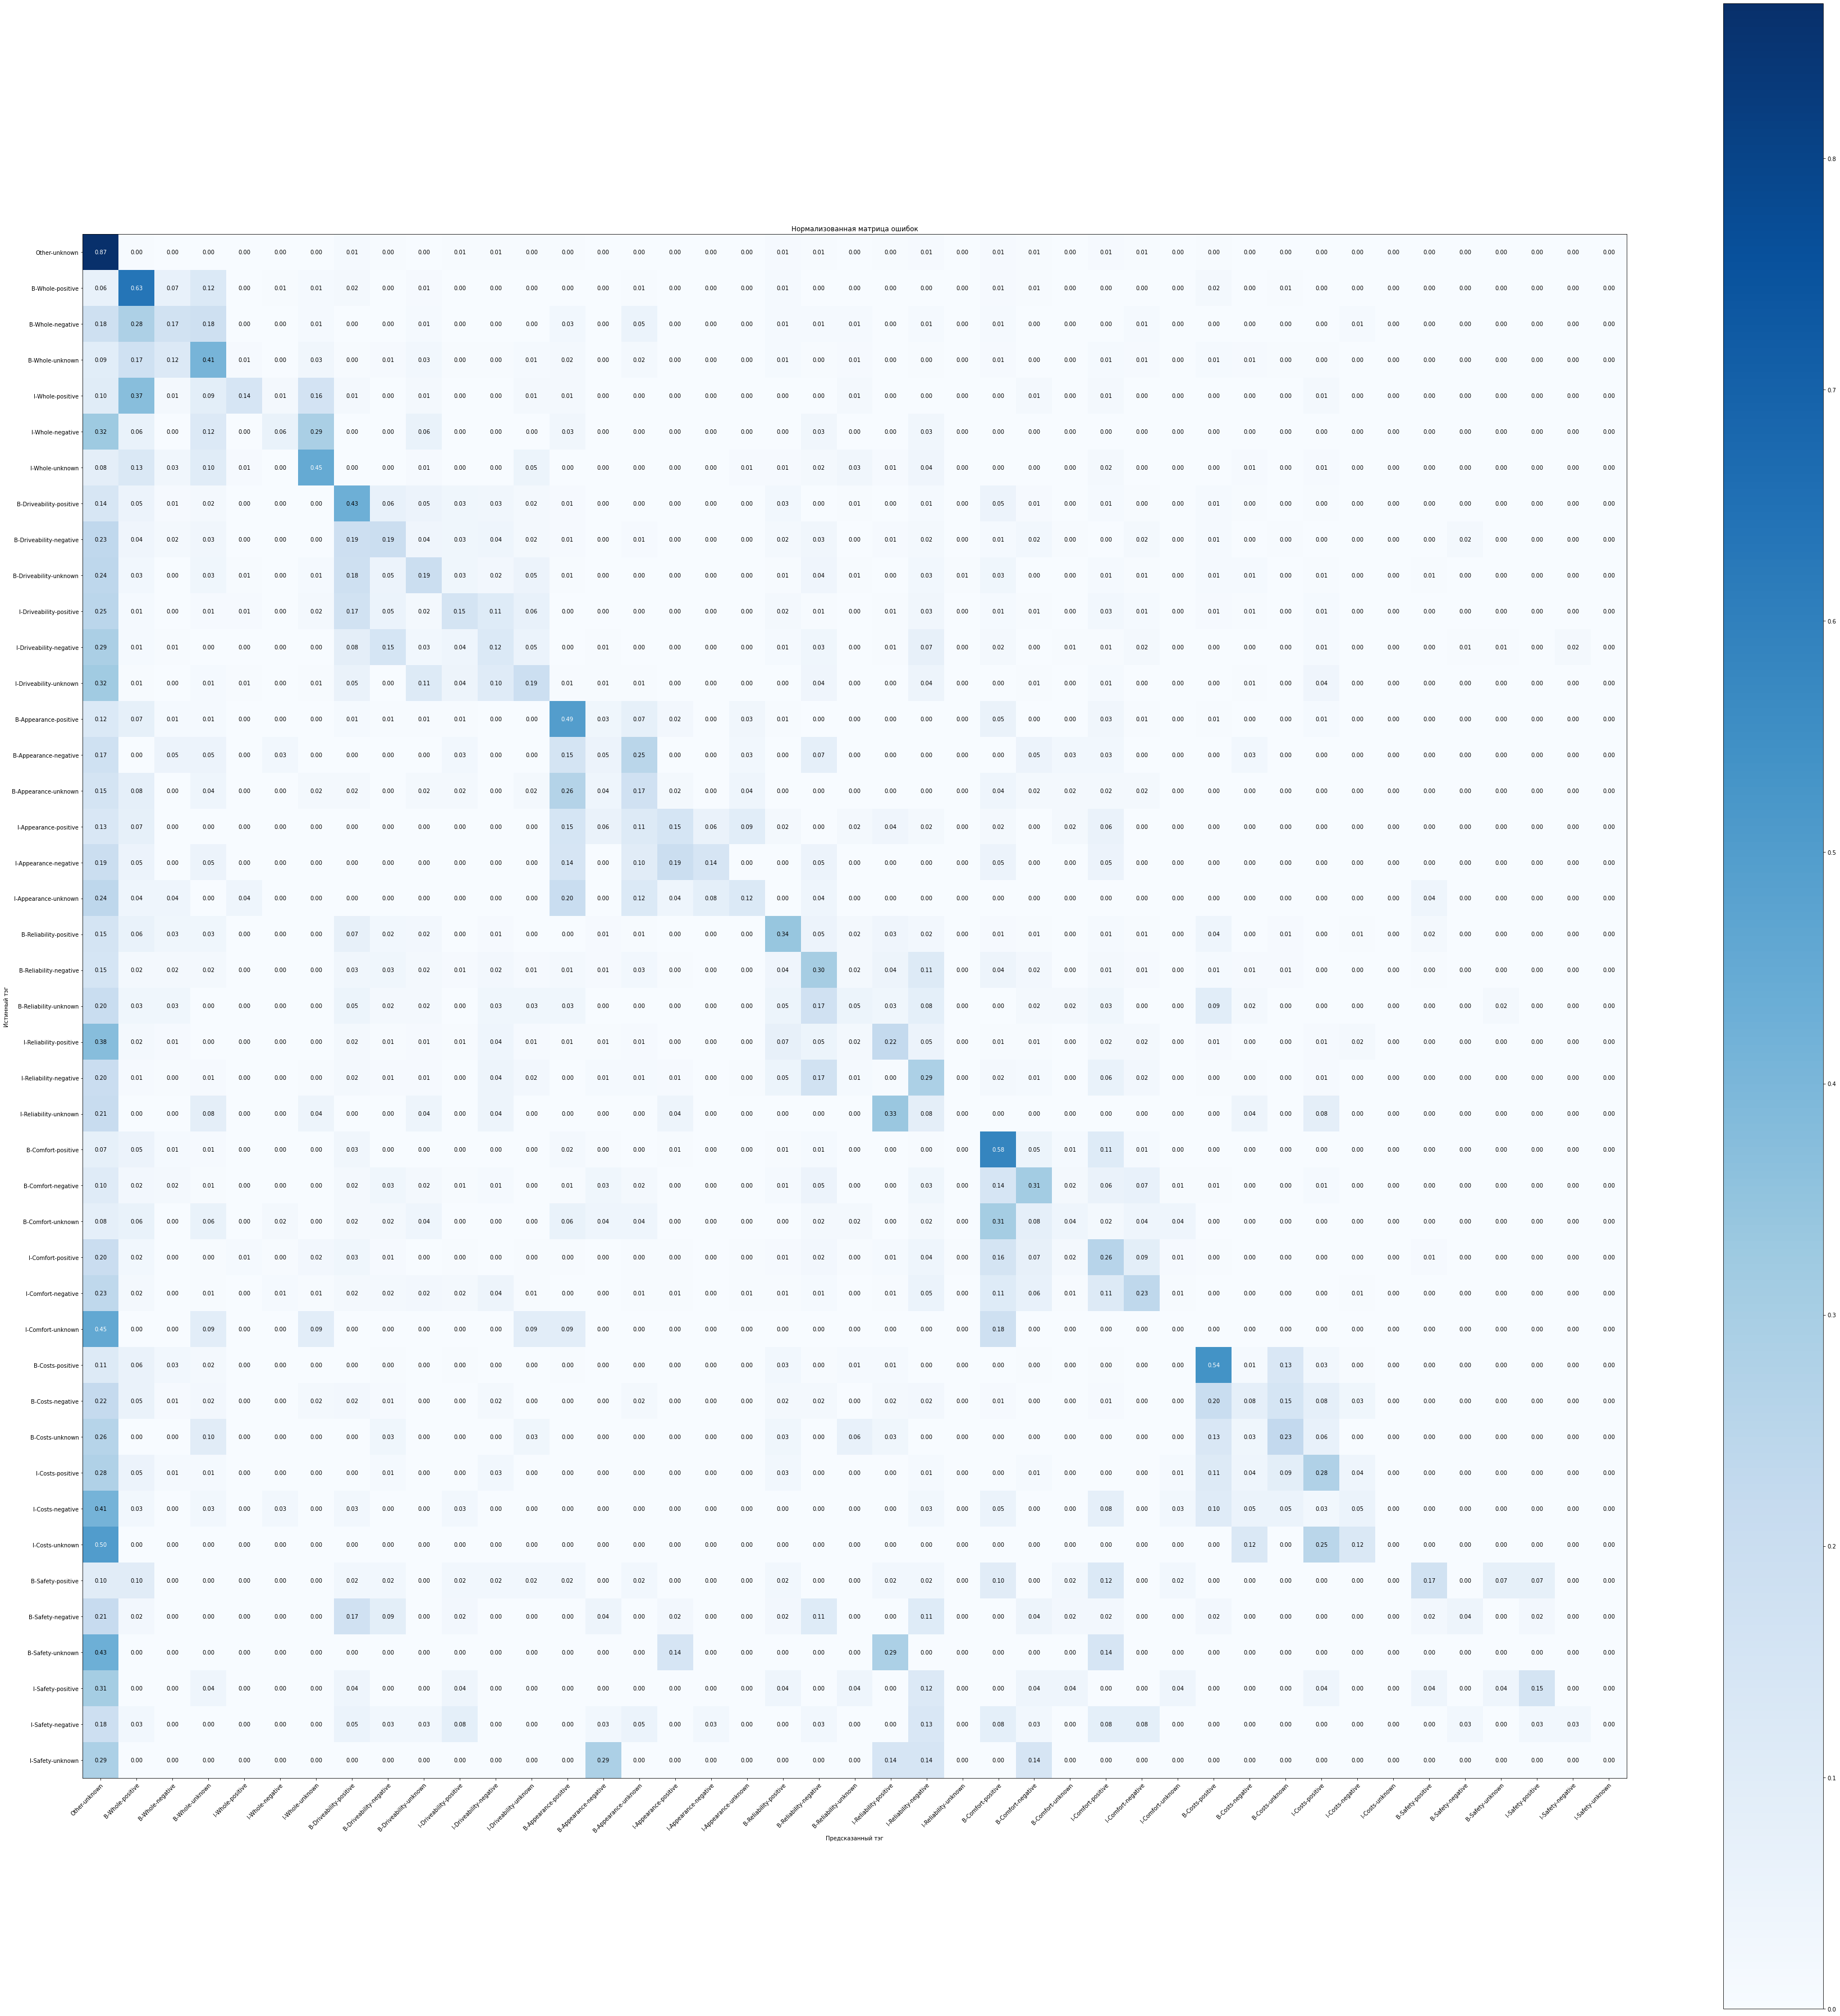

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=ordered_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # <- normalize

plot_confusion_matrix(cm, classes=ordered_labels, normalize=True, title='Нормализованная матрица ошибок')
plt.show()

## Метрики

In [39]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from prettytable import PrettyTable

metrics = PrettyTable(['Metric', 'Value'])
f1s = []
metrics.add_row(['Accuracy', f'{accuracy_score(y_true, y_pred):.2f}'])
for label in ordered_labels:
    precision = precision_score(y_true, y_pred, average=None, labels=[label], zero_division=0)[0]
    recall = recall_score(y_true, y_pred, average=None, labels=[label])[0]
    f1 = f1_score(y_true, y_pred, average=None, labels=[label])[0]
    metrics.add_row([f'Precision_{label}', f'{precision:.2f}'])
    metrics.add_row([f'Recall_{label}', f'{recall:.2f}'])
    metrics.add_row([f'F1_{label}', f'{f1:.2f}'])
    f1s.append(f1)

metrics.add_row(['F1-micro', f'{f1_score(y_true, y_pred, average="micro", labels=ordered_labels):.2f}'])
metrics.add_row(['F1-macro', f'{f1_score(y_true, y_pred, average="macro", labels=ordered_labels):.2f}'])

print(metrics)

+-----------------------------------+-------+
|               Metric              | Value |
+-----------------------------------+-------+
|              Accuracy             |  0.73 |
|      Precision_Other-unknown      |  0.94 |
|        Recall_Other-unknown       |  0.87 |
|          F1_Other-unknown         |  0.90 |
|     Precision_B-Whole-positive    |  0.34 |
|      Recall_B-Whole-positive      |  0.63 |
|        F1_B-Whole-positive        |  0.44 |
|     Precision_B-Whole-negative    |  0.08 |
|      Recall_B-Whole-negative      |  0.17 |
|        F1_B-Whole-negative        |  0.11 |
|     Precision_B-Whole-unknown     |  0.34 |
|       Recall_B-Whole-unknown      |  0.41 |
|         F1_B-Whole-unknown        |  0.37 |
|     Precision_I-Whole-positive    |  0.15 |
|      Recall_I-Whole-positive      |  0.14 |
|        F1_I-Whole-positive        |  0.15 |
|     Precision_I-Whole-negative    |  0.06 |
|      Recall_I-Whole-negative      |  0.06 |
|        F1_I-Whole-negative      